In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  f1_score, precision_score, recall_score


torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Generate Synthetic Emissions Data
We generate synthetic time series data for emissions, including both normal and anomalous sequences. 

In [46]:
def generate_emissions_data(n_samples=10000, sequence_length=24, n_features=5):
    time_steps = np.linspace(0, 2*np.pi, sequence_length)
    normal_data = []
    anomaly_data = []
    for i in range(n_samples):
        sequence = np.zeros((sequence_length, n_features))
        for feature in range(n_features):
            #we are creating a complex pattern / non linear data to simulate real world emissions and get our model to learn better
            base_pattern = (
                np.sin(time_steps + feature * 0.5) * (2 + feature)
                + np.cos(time_steps * (feature+1) * 0.7)
                + 0.5 * np.exp(0.1 * time_steps)
                + 0.2 * (np.sin(time_steps * 2 + feature) ** 2)
            )
            trend = np.log1p(np.linspace(1, 10, sequence_length)) * (feature + 1)
            noise = np.random.normal(0, 1.0, sequence_length)
            sequence[:, feature] = base_pattern + trend + noise + (feature + 1) * 10
        if i < n_samples * 0.5: # 50% of the data will have anomalies
            anomaly_type = np.random.choice(['spike', 'drift', 'noise', 'flat', 'regime'])
            # spike means a sudden increase in value of a feature
            # drift means a continous gradual increase in value of a feature
            # noise means adding random noise/flactuations to a value of a feature
            # flat means  the value of a feature is not chaning /constant
            # regime means switch in behavior of a feature ( maybe the sensor has malfunctioned )
            if anomaly_type == 'spike':
                spike_pos = np.random.randint(5, sequence_length-5)
                spike_feature = np.random.randint(0, n_features)
                sequence[spike_pos:spike_pos+3, spike_feature] *= np.random.uniform(4, 8)
            elif anomaly_type == 'drift':
                drift_start = np.random.randint(0, sequence_length//2)
                drift_feature = np.random.randint(0, n_features)
                drift_values = np.cumsum(np.random.normal(0.5, 0.2, sequence_length - drift_start))
                sequence[drift_start:, drift_feature] += drift_values
            elif anomaly_type == 'noise':
                noise_feature = np.random.randint(0, n_features)
                sequence[:, noise_feature] += np.random.normal(0, 6, sequence_length)
            elif anomaly_type == 'flat':
                flat_feature = np.random.randint(0, n_features)
                sequence[:, flat_feature] = np.mean(sequence[:, flat_feature])
            elif anomaly_type == 'regime':
                regime_feature = np.random.randint(0, n_features)
                regime_point = np.random.randint(sequence_length//3, 2*sequence_length//3)
                sequence[regime_point:, regime_feature] += np.random.uniform(10, 20)
            anomaly_data.append(sequence)
        else:
            normal_data.append(sequence)
    normal_data = np.array(normal_data)
    anomaly_data = np.array(anomaly_data)
    return normal_data, anomaly_data

normal_sequences, anomaly_sequences = generate_emissions_data(
    n_samples=10000, sequence_length=24, n_features=5
)

## Preprocess Data
We scale the data to avoid exploding gradients and we split it into training, normal test, and anomaly test sets.

In [47]:
def preprocess_data(normal_data, anomaly_data, train_split=0.8):
    n_train = int(len(normal_data) * train_split)
    train_data = normal_data[:n_train]
    test_normal = normal_data[n_train:]
    original_shape = train_data.shape
    train_flat = train_data.reshape(-1, train_data.shape[-1])

    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_flat)
    train_scaled = train_scaled.reshape(original_shape)

    test_normal_flat = test_normal.reshape(-1, test_normal.shape[-1])
    test_normal_scaled = scaler.transform(test_normal_flat)
    test_normal_scaled = test_normal_scaled.reshape(test_normal.shape)

    anomaly_flat = anomaly_data.reshape(-1, anomaly_data.shape[-1])
    anomaly_scaled = scaler.transform(anomaly_flat)
    anomaly_scaled = anomaly_scaled.reshape(anomaly_data.shape)

    train_tensor = torch.FloatTensor(train_scaled)
    test_normal_tensor = torch.FloatTensor(test_normal_scaled)
    anomaly_tensor = torch.FloatTensor(anomaly_scaled)
    
    return train_tensor, test_normal_tensor, anomaly_tensor, scaler

train_data, test_normal_data, test_anomaly_data, data_scaler = preprocess_data(
    normal_sequences, anomaly_sequences
)

## LSTM Autoencoder Model


In [48]:
class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, num_layers=2, dropout=0.2):
        super(LSTM_Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.encoder = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.decoder = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        self.output_layer = nn.Linear(hidden_dim, input_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        encoded_seq, (h_n, c_n) = self.encoder(x)
        compressed_repr = h_n[-1]
        decoder_input = torch.zeros(batch_size, seq_len, self.input_dim, device=x.device)
        decoder_outputs, _ = self.decoder(decoder_input, (h_n, c_n))
        reconstructed = self.output_layer(decoder_outputs)
        return reconstructed, compressed_repr

model = LSTM_Autoencoder(
    input_dim=5,
    hidden_dim=64,
    num_layers=2,
    dropout=0.2
).to(device)

from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
LSTM_Autoencoder                         --
├─LSTM: 1-1                              51,456
├─LSTM: 1-2                              51,456
├─Linear: 1-3                            325
├─Dropout: 1-4                           --
Total params: 103,237
Trainable params: 103,237
Non-trainable params: 0

## Train the Autoencoder
Train the model on normal sequences using mean squared error loss.

In [49]:
def train_autoencoder(model, train_data, epochs=50, batch_size=32, learning_rate=0.001):
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)

    dataset = torch.utils.data.TensorDataset(train_data)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True, drop_last=True
    )

    training_losses = []
    model.train()
    for epoch in range(epochs):
        epoch_losses = []
        for batch_idx, (batch_data,) in enumerate(dataloader):
            batch_data = batch_data.to(device)
            optimizer.zero_grad()
            reconstructed, _ = model(batch_data)
            loss = loss_fn(reconstructed, batch_data)
            loss.backward()
            #we clip the gradients to avoid exploding  gradients 
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_losses.append(loss.item())

        avg_loss = np.mean(epoch_losses)
        training_losses.append(avg_loss)
        scheduler.step(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}')
    return training_losses

training_losses = train_autoencoder(
    model, train_data, epochs=50, batch_size=32, learning_rate=0.001
)

Epoch [10/50], Loss: 0.173341
Epoch [20/50], Loss: 0.160426
Epoch [30/50], Loss: 0.149792
Epoch [40/50], Loss: 0.139798
Epoch [50/50], Loss: 0.128795


## Detect Anomalies
We compute reconstruction errors for both normal and anomalous sequences. A threshold (95% here) is used to flag anomalies.

In [50]:
def detect_anomalies(model, normal_data, anomaly_data, threshold_percentile=95):

    model.eval()
    loss_fn = nn.MSELoss(reduction='none')

    normal_errors = []
    with torch.no_grad():
        for i in range(0, len(normal_data), 32):
            batch = normal_data[i:i+32].to(device)
            reconstructed, _ = model(batch)
            loss = loss_fn(reconstructed, batch).mean(dim=(1, 2))
            normal_errors.extend(loss.cpu().numpy())

    anomaly_errors = []
    with torch.no_grad():
        for i in range(0, len(anomaly_data), 32):
            batch = anomaly_data[i:i+32].to(device)
            reconstructed, _ = model(batch)
            loss = loss_fn(reconstructed, batch).mean(dim=(1, 2))
            anomaly_errors.extend(loss.cpu().numpy())
            
    threshold = np.percentile(normal_errors, threshold_percentile)
    normal_predictions = np.array(normal_errors) > threshold
    anomaly_predictions = np.array(anomaly_errors) > threshold

    y_true = np.concatenate([np.zeros_like(normal_predictions), np.ones_like(anomaly_predictions)])
    y_pred = np.concatenate([normal_predictions, anomaly_predictions])

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_score_val = f1_score(y_true, y_pred)
    results = {
        'threshold': threshold,
        'normal_errors': normal_errors,
        'anomaly_errors': anomaly_errors,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score_val,
        'normal_predictions': normal_predictions,
        'anomaly_predictions': anomaly_predictions
    }
    return results

detection_results = detect_anomalies(model, test_normal_data, test_anomaly_data)

print(f"\nAnomaly Detection Results:")
print(f"Threshold: {detection_results['threshold']:.4f}")
print(f"Precision: {detection_results['precision']:.3f}")
print(f"Recall: {detection_results['recall']:.3f}")
print(f"F1-Score: {detection_results['f1_score']:.3f}")

#95% of normal sequences are below the threshold , any sequence above it will be flagged as an anomaly 


Anomaly Detection Results:
Threshold: 0.1638
Precision: 0.989
Recall: 0.923
F1-Score: 0.955


## Visualize Training and Results
Plot the training loss curve and the distribution of reconstruction errors for normal and anomalous sequences.

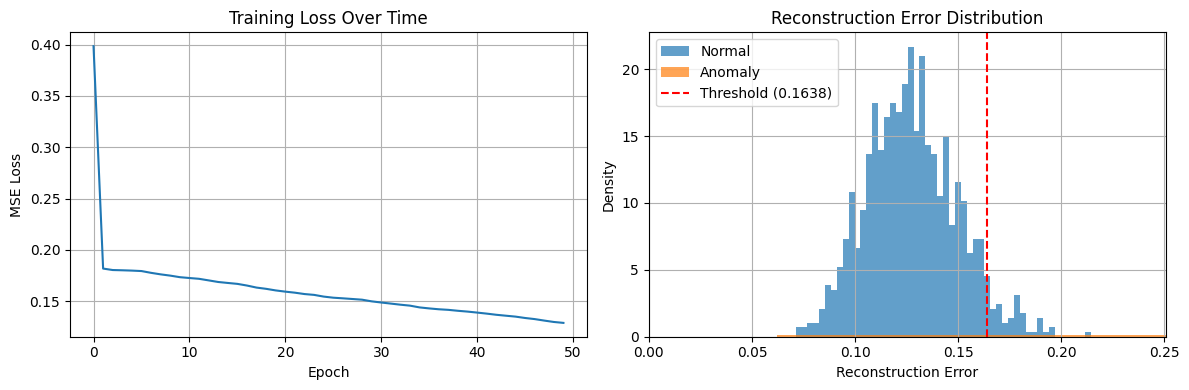

In [77]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(detection_results['normal_errors'], bins=50, alpha=0.7, label='Normal', density=True)
plt.hist(detection_results['anomaly_errors'], bins=50, alpha=0.7, label='Anomaly', density=True)
plt.axvline(detection_results['threshold'], color='red', linestyle='--', label=f'Threshold ({detection_results["threshold"]:.4f})')

plt.xlabel('Reconstruction Error')
plt.ylabel('Density')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.grid(True)

max_x = np.percentile(detection_results['anomaly_errors'], 10)
plt.xlim(0, max_x)


plt.tight_layout()
plt.show()